# **Chapter 8: Image compression**
In this notebook we walk through core ideas of **image compression** using the *Cameraman* image from `skimage.data`. We relate entropy to bit depth, evaluate lossy quantization with RMSE/PSNR, and explore lossless (Huffman, run‑length) and transform coding (block DCT, coefficient thresholding, and quantization). The goal is to see how each step trades off rate and distortion in an explanatory manner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.exposure import histogram
plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

In [2]:
I = data.camera()

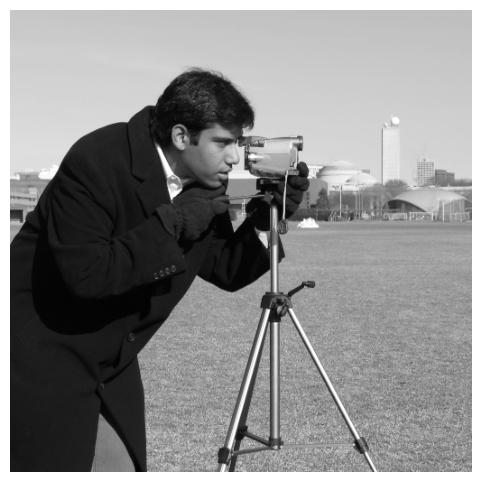

In [3]:
plt.imshow(I)
plt.axis('off');

### Entropy
We begin by defining an entropy function that takes a **normalized histogram** and returns Shannon entropy (base‑2) in bits. Computing entropy for the image gives a lower bound (per symbol) for any lossless code and a useful reference when we later change bit depth.

In [4]:
def entropy(p):
    i = p > 0
    return -sum(p[i]*np.log2(p[i]))

In [5]:
p, x = histogram(I,normalize=True)

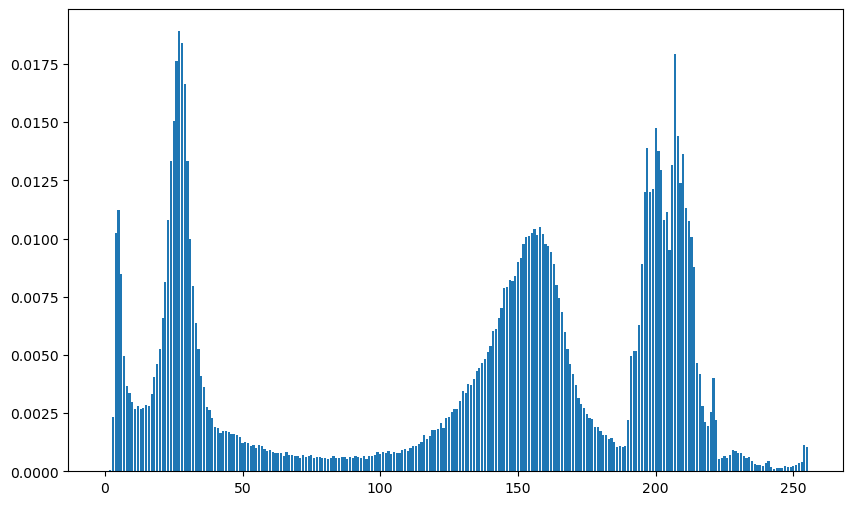

In [6]:
plt.bar(x,p);

In [7]:
print(entropy(p))

7.231695011055708


The entropy tracks the number of effective bits used to represent the image. We keep only the most significant bits (the top four) and visualize both the result and its histogram to see how aggressive quantization lowers entropy and impacts quality.

In [8]:
J = np.bitwise_and(I,2**7+2**6+2**5+2**4)

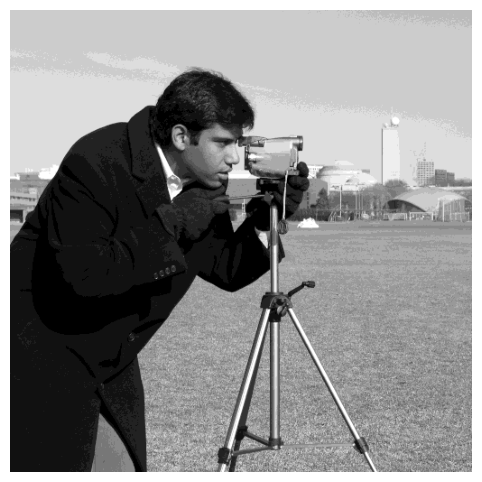

In [9]:
plt.imshow(J)
plt.axis('off');

In [10]:
p2, x2 = histogram(J//16,normalize=True)

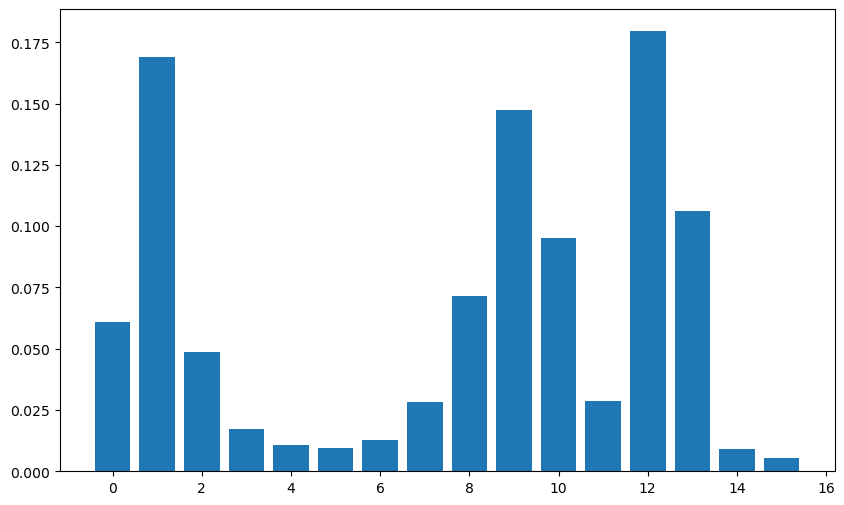

In [11]:
plt.bar(x2,p2);

In [12]:
print(entropy(p2))

3.3927289176776685


We observe visible **artifacts** and **false contours** (banding) in the coarsely quantized image, while the entropy drops below 4 bits/pixel. This is expected: fewer gray levels reduce uncertainty but also remove subtle tone gradients.

### Image quality
To compare lossy results, we use two standard metrics: the **root‑mean‑square error** $\mathrm{RMSE}(I,J)$ and the **peak signal‑to‑noise ratio** $\mathrm{PSNR}=20\log_{10}(255/\mathrm{RMSE})$ for 8‑bit images. Higher PSNR indicates better fidelity; values above ~40 dB are typically considered visually good for natural images.

In [13]:
def rmse(a,b):
    return np.sqrt(((a+0.0-b)**2).mean())

In [14]:
def psnr(a,b):
    return 20*np.log10(255.0/rmse(a,b))

Now we quantify the quality of the previously quantized image by computing RMSE and PSNR relative to the original. This gives an objective complement to the visual inspection above and lets us compare methods on the same scale.

In [15]:
print(rmse(I,J))

8.825488535729175


In [16]:
print(psnr(I,J))

29.216028505954455


### Huffman coding
**Huffman coding** is a canonical variable‑length, prefix‑free code that assigns shorter codewords to more probable symbols. We use a public implementation to build a codebook from the symbol frequencies of our quantized image and inspect the resulting mapping.

In [17]:
# code from https://rosettacode.org/wiki/Huffman_coding
from heapq import heappush, heappop, heapify
 
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

Next, we apply the Huffman encoder to the quantized data and list the $(\text{symbol},\text{codeword})$ pairs. From this we can compute the **average codeword length** and directly compare it with the image entropy.

In [18]:
sf = dict(zip(x2,p2))

In [19]:
print(sf)

{0: 0.06097412109375, 1: 0.16890716552734375, 2: 0.04875946044921875, 3: 0.01726531982421875, 4: 0.010555267333984375, 5: 0.00942230224609375, 6: 0.012897491455078125, 7: 0.028217315673828125, 8: 0.07145309448242188, 9: 0.14727020263671875, 10: 0.09503173828125, 11: 0.02873992919921875, 12: 0.17951583862304688, 13: 0.10631179809570312, 14: 0.009235382080078125, 15: 0.005443572998046875}


In [20]:
huff = encode(sf)

In [21]:
print(huff)

[[12, '00'], [1, '111'], [9, '101'], [13, '011'], [0, '1000'], [2, '0100'], [8, '1100'], [10, '1101'], [7, '01011'], [11, '10010'], [3, '100110'], [6, '010100'], [4, '1001111'], [5, '1001110'], [14, '0101011'], [15, '0101010']]


We calculate the average codeword length and compare it to the entropy of the same distribution. As expected for Huffman coding, the two values are very close, demonstrating near‑optimal lossless compression for memoryless sources.

In [22]:
acl=sum([sf[c[0]]*len(c[1]) for c in huff])
print(acl)

3.4397315979003906


In [23]:
print(entropy(p2))

3.3927289176776685


Finally, we compute the **relative redundancy** using a fixed‑length baseline of 4 bits/symbol (because we kept the top four bits): $R=1-\tfrac{\text{avg length}}{4}$. This shows that, for this distribution, variable‑length coding alone yields modest savings unless the histogram is strongly skewed.

In [24]:
print(1 - acl/4)

0.14006710052490234


### Bit-plane coding
Here we visualize the image’s bit‑planes using conventional **binary** coding and **Gray** coding. Gray code changes only one bit between adjacent gray levels, reducing transitions and often producing patterns that are more amenable to subsequent run‑length coding.

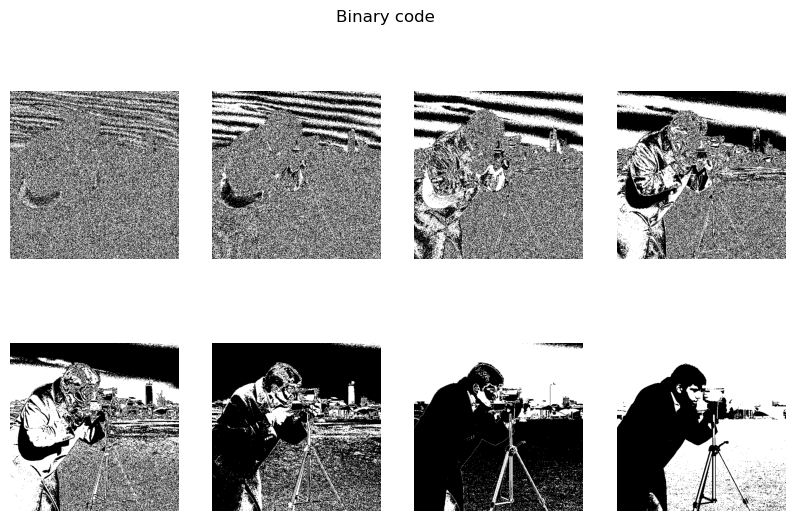

In [25]:
f,ax = plt.subplots(2,4)
f.suptitle('Binary code')
for i in range(8):
    ax[i//4,i%4].imshow(np.bitwise_and(I,2**i)).axes.set_axis_off()

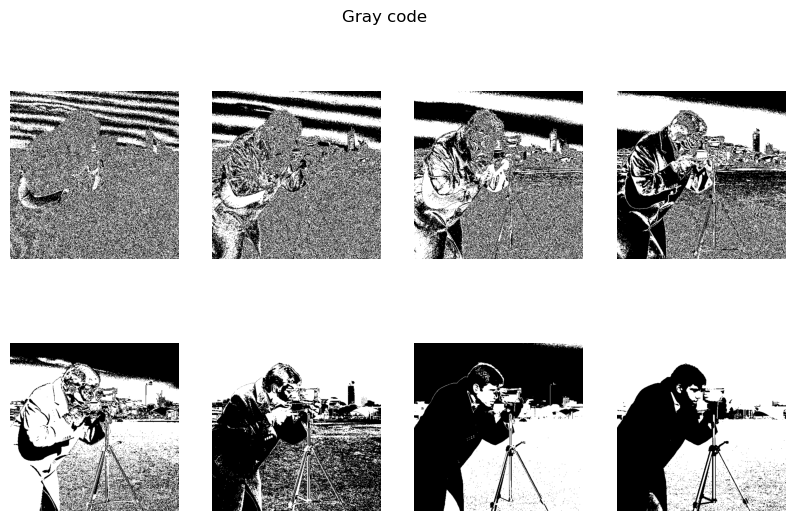

In [26]:
f,ax = plt.subplots(2,4)
f.suptitle('Gray code')
for i in range(7):
    b0 = np.bitwise_and(I,2**i)>0
    b1 = np.bitwise_and(I,2**(i+1))>0
    ax[i//4,i%4].imshow(np.logical_xor(b0,b1)).axes.set_axis_off()
ax[1,3].imshow(np.bitwise_and(I,2**7)).axes.set_axis_off()

We see that Gray‑coded planes look more structured and piecewise‑constant, which can increase run lengths. This property will be useful when combined with run‑length encoding.

### Run-length coding
We demonstrate **run‑length encoding (RLE)** using publicly available reference code and start with a simple example string containing long repeats. The encoder represents consecutive identical symbols compactly as $(\text{symbol},\text{count})$ pairs.

In [27]:
# code from https://www.rosettacode.org/wiki/Run-length_encoding
from itertools import groupby
def run_encode(input_string):
    return [(k, len(list(g))) for k,g in groupby(input_string)]

def run_decode(lst):
    return ''.join(c * n for c,n in lst)

In [28]:
txt = "aaaaahhhhhhmmmmmmmuiiiiiiiaaaaaa"

In [29]:
r = run_encode(txt)

In [30]:
print(r)

[('a', 5), ('h', 6), ('m', 7), ('u', 1), ('i', 7), ('a', 6)]


In [31]:
print(run_decode(r))

aaaaahhhhhhmmmmmmmuiiiiiiiaaaaaa


From the relative redundancy we observe that RLE performs well when long runs dominate the data. This motivates pairing RLE with representations (such as Gray‑coded bit‑planes or zigzag‑scanned DCT coefficients) that produce long sequences of identical values.

In [32]:
print(1-(2*len(r))/len(txt))

0.625


### Discrete cosine transform (DCT)
The **2‑D DCT** is the workhorse of transform coding (e.g., JPEG). We first reshape the image into $8\times8$ blocks, organizing data so that block indices form the first and third axes and the spatial coordinates the second and fourth axes.

In [33]:
m,n = I.shape
B=I.reshape(m//8,8,n//8,8)

In [34]:
B.shape

(64, 8, 64, 8)

As an illustration, we display a single $8\times8$ block from the middle of the image. This lets us track how DCT redistributes its energy in the next step.

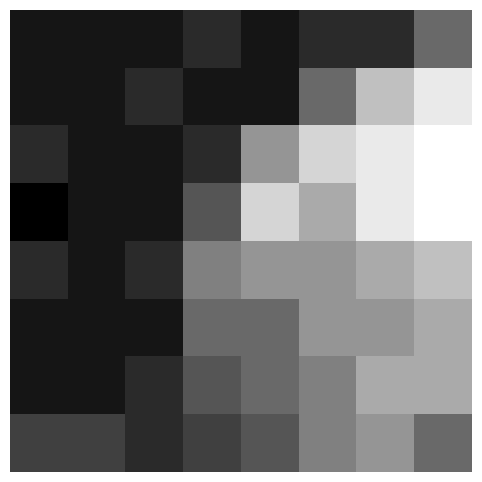

In [35]:
plt.imshow(B[31,:,32,:])
plt.axis('off');

We then apply the separable 2‑D DCT by running the 1‑D DCT along each spatial dimension in turn (`norm='ortho'`). The result is a block of transform coefficients with a strong low‑frequency component near the top‑left corner.

In [36]:
from scipy.fftpack import dct, idct

def blockwise_dct2(a):
    return dct(dct(a, axis=1, norm='ortho'), axis=3, norm='ortho')

def blockwise_idct2(a):
    return idct(idct(a, axis=1 , norm='ortho'), axis=3 , norm='ortho')

In [37]:
D = blockwise_dct2(B)

Here is the same block after the DCT. Note that the DC term captures average intensity while the higher‑frequency terms (away from the corner) encode edges and texture.

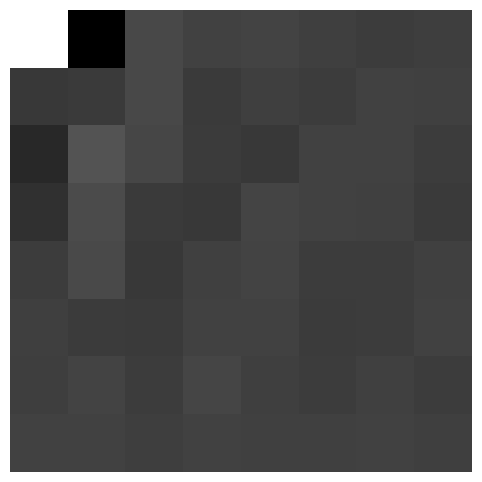

In [38]:
plt.imshow(D[31,:,32,:])
plt.axis('off');

Most coefficients are close to zero, indicating that natural images are **compressible** in the DCT domain. We will exploit this sparsity by zeroing small‑magnitude coefficients.

In [39]:
print(D[31,:,32,:].astype('int'))

[[ 67 -22   2   1   1   0   0   0]
 [ -2  -1   3  -1   0   0   1   0]
 [ -7   7   2  -1  -2   0   0   0]
 [ -4   4  -1  -2   1   0   0  -1]
 [ -1   3  -2   0   1   0   0   0]
 [  0  -1  -1   0   1  -1   0   0]
 [  0   1   0   2   0   0   0   0]
 [  0   1   0   0   0   0   0   0]]


This sparsity pattern is consistent across blocks: the coefficient histogram is tightly centered near zero with relatively light tails. We quantify the spread to guide threshold selection.

In [40]:
print((D.min(),D.max()))

(-669.0614525464038, 1954.7500000000002)


In [41]:
h, x = histogram(D,1000)

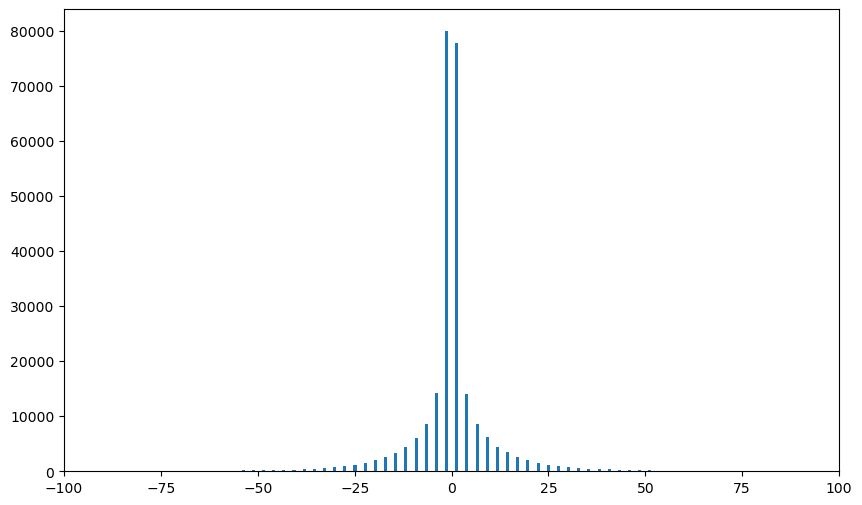

In [42]:
plt.bar(x, h)
plt.xlim(-100,100);

More than **90%** of coefficients fall within $[-25,25]$. This empirical fact suggests that discarding coefficients in this small‑magnitude band will remove little energy.

In [43]:
(abs(D)<25).mean()

0.9331588745117188

We therefore set coefficients with $|c|\le25$ to zero and apply the block‑wise inverse DCT to reconstruct the image. This **hard thresholding** yields significant coefficient sparsity with surprisingly mild visual impact.

In [44]:
D[abs(D)<25]=0

In [45]:
J=blockwise_idct2(D).reshape(m,n).clip(0,255)

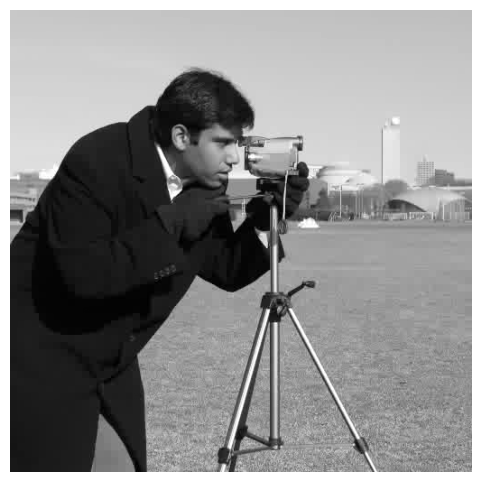

In [46]:
plt.imshow(J)
plt.axis('off');

The reconstructed image shows almost no visible distortion; the difference image and a low RMSE confirm the small error introduced by thresholding.

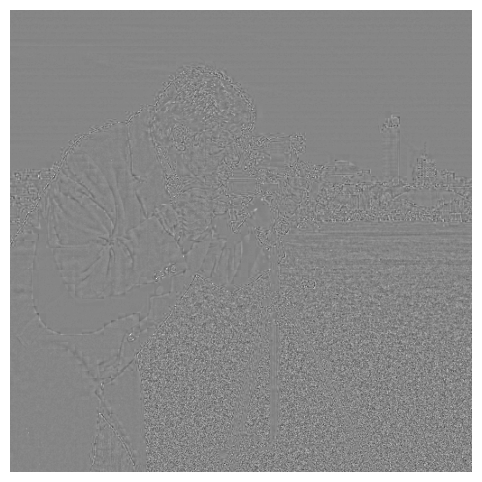

In [47]:
plt.imshow(I-J)
plt.axis('off');

In [48]:
print(rmse(I,J))

6.290626743157422


### Quantization
For practical coding we must **quantize** the surviving DCT coefficients. Here we divide coefficients by 16 and round to integers before storing them in 8‑bit form, which coarsens precision but reduces storage dramatically.

In [49]:
Q = (D//16).astype('int8')

During reconstruction, we multiply by 16 to **dequantize** prior to the inverse DCT. In this setting the quantization step introduces only a small quality loss, as confirmed visually and by error metrics.

In [50]:
J=blockwise_idct2(Q*16.0).reshape(m,n).clip(0,255)

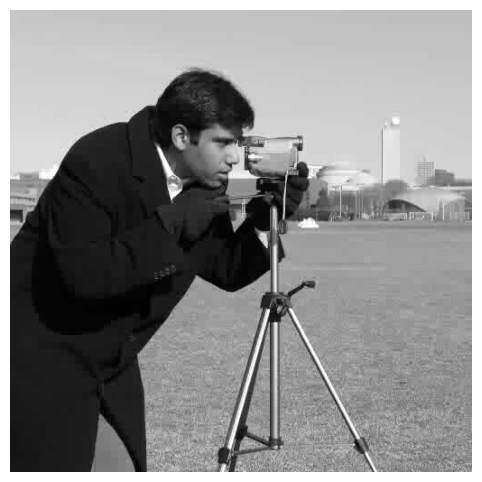

In [51]:
plt.imshow(J)
plt.axis('off');

In [52]:
print(rmse(I,J))

6.724636504799736


We also compute the entropy of the quantized coefficient stream. The low entropy indicates that, with an appropriate variable‑length code, we can encode the coefficients at **sub‑1 bit/pixel** on this example.

In [53]:
p3,x3 = histogram(Q, normalize=True)

In [54]:
print(entropy(p3))

0.6759325056187684


Moreover, using **zigzag scanning** to group low‑frequency terms first and then applying RLE to strings of trailing zeros can further increase compression. Many practical codecs combine these ideas to achieve high compression ratios with controlled distortion. To demonstrate this, here is the block we used as an example above. Now, we can see that after quantization it only contains the DC coefficient as a non-zero value, which makes the compression of this block extremely efficient.

In [55]:
print(Q[31,:,32,:])

[[4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
